In [1]:
from collections import Counter
import os
from glob import glob
import re
import copy 

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
donor_dict = {'A1_06': [], 
              'A1_30': []}

In [3]:
scite_input_path = f'/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_27_mt-scite_2_pos_filter/'

In [4]:
datasets = ['A1_06', 'A1_30']

In [5]:
scite_input_path

'/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_27_mt-scite_2_pos_filter/'

In [6]:
scite_stdout_clones = donor_dict.copy()
for donor in datasets: 
    scite_stdout_clones[donor] = list(os.listdir(scite_input_path + donor))

In [7]:

# Get log likelihood scores and n trees
exp_std = copy.deepcopy(donor_dict)
lhood = copy.deepcopy(donor_dict)
n_trees = copy.deepcopy(donor_dict)

for donor in datasets: 
    lhood[donor] = {}
    n_trees[donor] = {}
    for clone in scite_stdout_clones[donor]:
        filename = f"{scite_input_path}{donor}/{clone}/{clone}.stdout.txt"
        try:
            file = open(filename, "r")
        except: 
            continue
        
        lhood[donor][clone] = []
        n_trees[donor][clone] = []
        exp_std[donor].append(clone)
        for line in file:
            if 'best log score for tree:' in line:
                score = line.split('	')[1].rstrip()
                lhood[donor][clone].append(score)
                lhood[donor][clone] = [float(x) for x in lhood[donor][clone]]
                #print(lhood)
            if 'opt tree' in line:
                n = line.split(' opt')[0].lstrip()
                n_trees[donor][clone].append(n)
                n_trees[donor][clone] = [int(x) for x in n_trees[donor][clone]]
                #print(n_trees)

In [8]:
pmat_names = copy.deepcopy(donor_dict)
n_pmat_rows = copy.deepcopy(donor_dict)
pmat_info = copy.deepcopy(donor_dict)
n_samples = copy.deepcopy(donor_dict)
for donor in datasets: 

    pmat_info[donor] = {}
    pmat_input_path = f'{scite_input_path}{donor}_matrix_output_clonal/'
    
    n_samples[donor] = {}

    for filename in exp_std[donor]:
        file = open(f"{pmat_input_path}{filename}.csv", "r")
        n = 0 
        for line in file.readlines(): 
            n += 1 
            n_samples[donor][filename] = len(line.split(' ')) 
        n_pmat_rows[donor].append(n)
        pmat_names[donor].append(filename)

    # store in a dict
    pmat_info[donor] = {pmat_names[donor][i]: n_pmat_rows[donor][i] for i in range(len(pmat_names[donor]))}

In [9]:

performance = copy.deepcopy(donor_dict)

for donor in datasets:
    performance[donor] = pd.DataFrame(index=exp_std[donor])
    for clone in exp_std[donor]: 
        #print(clone)
        n_samples_clone = n_samples[donor][clone]

        performance[donor].loc[clone, 'lhood'] = lhood[donor][clone][0]
        performance[donor].loc[clone, 'lhood'] = performance[donor].loc[clone, 'lhood'].astype(float)

        performance[donor].loc[clone, 'n trees'] = n_trees[donor][clone][0]

        runs = performance[donor].loc[clone].index.tolist()
        performance[donor].loc[clone] = performance[donor].loc[clone].sort_index()

        performance[donor].loc[clone, 'n_muts'] = pmat_info[donor][clone]

        performance[donor].loc[clone, 'entries'] = performance[donor].loc[clone, 'n_muts']*n_samples_clone

        performance[donor].loc[clone, 'clone_size'] = n_samples[donor][clone]

        performance[donor].loc[clone, 'lhood_entries'] = performance[donor].loc[clone, 'lhood']/performance[donor].loc[clone, 'entries']


In [10]:
lhood['A1_30']['0.0556_B102']

[-1.7976931348623157e+308]

In [11]:
n_samples['A1_06']['0.0556_A28']

37

In [12]:
#performance['A1_30'].sort_values('clone_size')

In [13]:
performance['A1_06'].sort_values('lhood').head(8)

,lhood,n trees,n_muts,entries,clone_size,lhood_entries
0.0556_A41,-1.797693e+308,16.0,3.0,24.0,8.0,-7.490388e+306
0.0556_A28,-1.797693e+308,170800.0,9.0,333.0,37.0,-5.398478e+305
0.0556_A397,-1.797693e+308,16807.0,6.0,72.0,12.0,-2.496796e+306
0.0556_A48,-1.797693e+308,180838.0,14.0,686.0,49.0,-2.620544e+305
0.0556_A171,-1.797693e+308,164808.0,8.0,152.0,19.0,-1.182693e+306
0.0556_A39,-8.608072e+01,2.0,13.0,481.0,37.0,-1.789620e-01
0.0556_A61,-8.403893e+01,7.0,20.0,1760.0,88.0,-4.774939e-02
0.0556_A60,-6.339074e+01,6.0,14.0,350.0,25.0,-1.811164e-01


In [14]:
performance['A1_06'] = performance['A1_06'].drop(["0.0556_A397", "0.0556_A41", "0.0556_A171", "0.0556_A28", "0.0556_A48"])

In [15]:
performance['A1_30'].sort_values('lhood').head()


,lhood,n trees,n_muts,entries,clone_size,lhood_entries
0.0556_B102,-1.797693e+308,182801.0,16.0,624.0,39.0,-2.880918e+305
0.0556_B243,-1.797693e+308,121326.0,7.0,112.0,16.0,-1.605083e+306
0.0556_B39,-1.233502e+02,2.0,17.0,816.0,48.0,-1.511644e-01
0.0556_B205,-8.093349e+01,1.0,9.0,351.0,39.0,-2.305797e-01
0.0556_B18,-5.917890e+01,1.0,8.0,112.0,14.0,-5.283831e-01


In [16]:
performance['A1_30'] = performance['A1_30'].drop(["0.0556_B102", "0.0556_B243"])

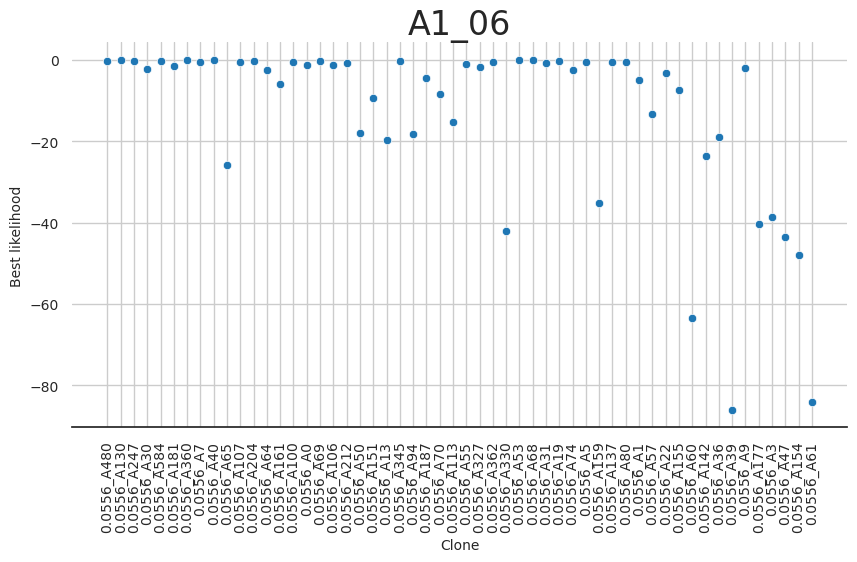

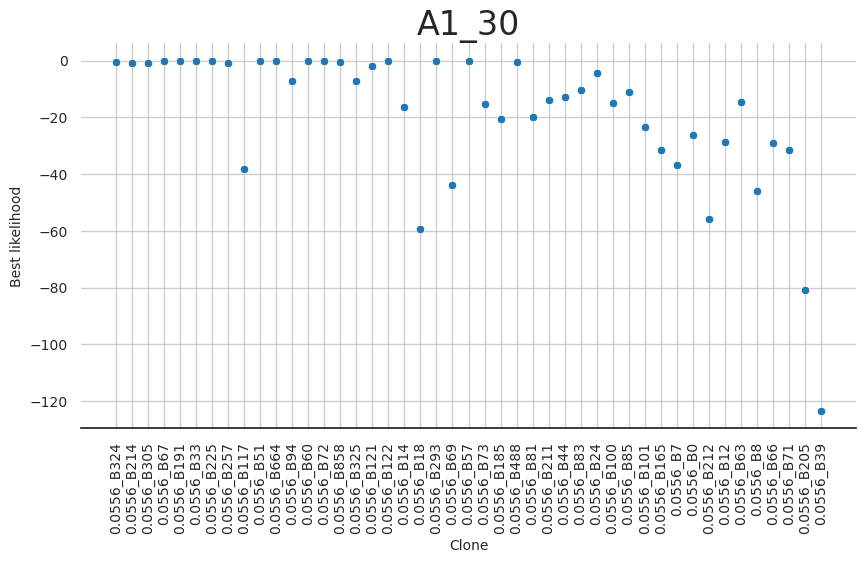

In [17]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.scatterplot(data=performance[donor], x=performance[donor].index, y="lhood", lw=1) #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Best likelihood')
        plt.xlabel('Clone')
        plt.show()

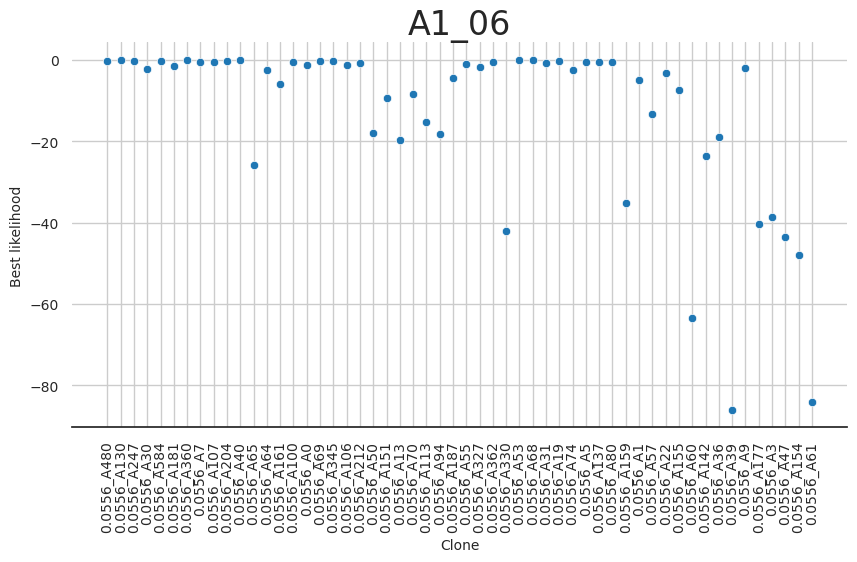

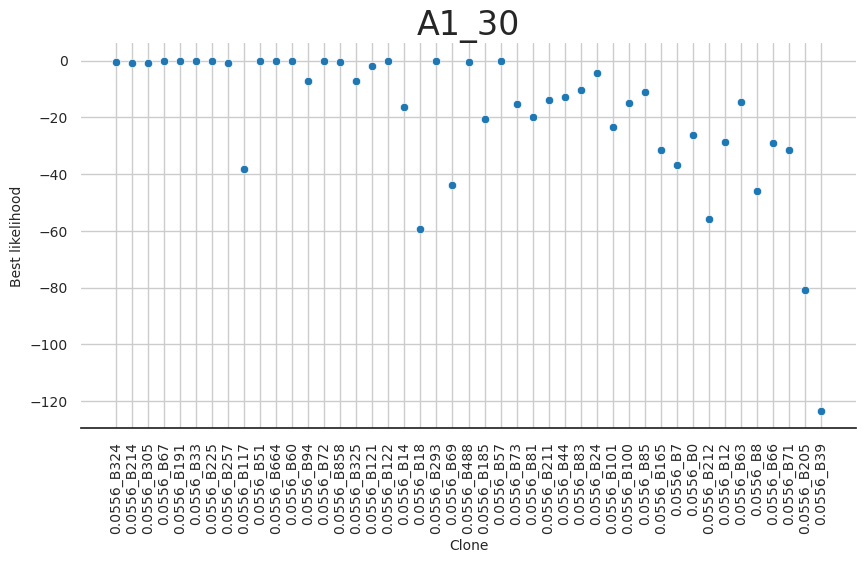

In [29]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.scatterplot(data=performance[donor], x=performance[donor].index, y="lhood", lw=1) #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Best likelihood')
        plt.xlabel('Clone')
        plt.show()

In [26]:
performance['A1_06'].head()

,lhood,n trees,n_muts,entries,clone_size,lhood_entries
0.0556_A480,-0.381580,1.0,2.0,16.0,8.0,-0.023849
0.0556_A130,-0.144147,1.0,2.0,16.0,8.0,-0.009009
0.0556_A247,-0.230028,1.0,2.0,16.0,8.0,-0.014377
0.0556_A30,-2.345966,1.0,2.0,18.0,9.0,-0.130331
0.0556_A584,-0.215410,1.0,2.0,18.0,9.0,-0.011967


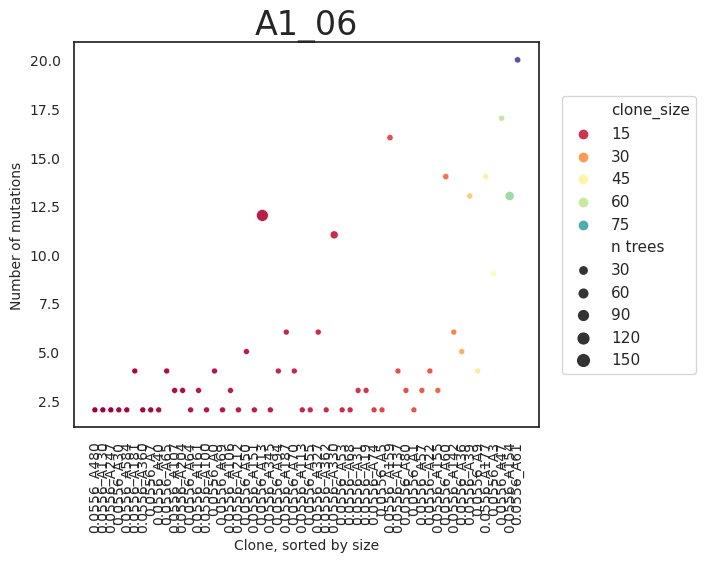

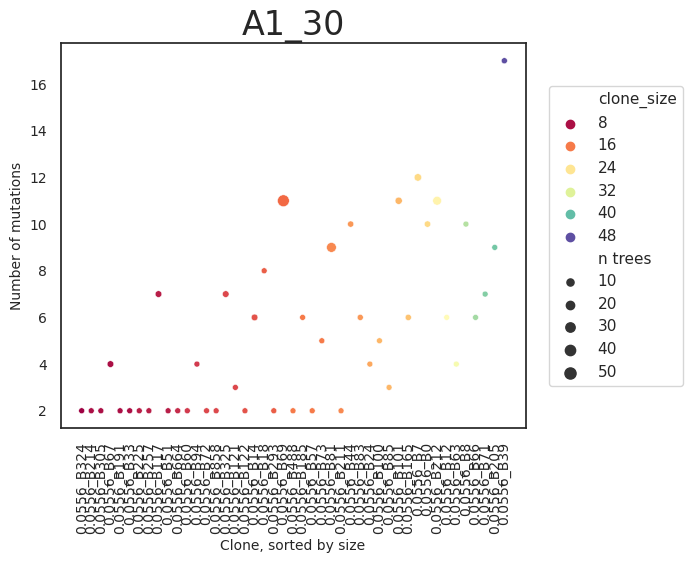

In [44]:

for donor in datasets:
    with plot_style(figsize=(6, 5), ticklabelsize=10, labelsize=10):
        sns.set_style('white')
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.scatterplot(data=performance[donor], x=performance[donor].index, y="n_muts", hue='clone_size', size='n trees', palette=plt.cm.Spectral)#, lw=1) #marker='o'
        #plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Number of mutations')
        plt.xlabel('Clone, sorted by size')
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
        plt.show()

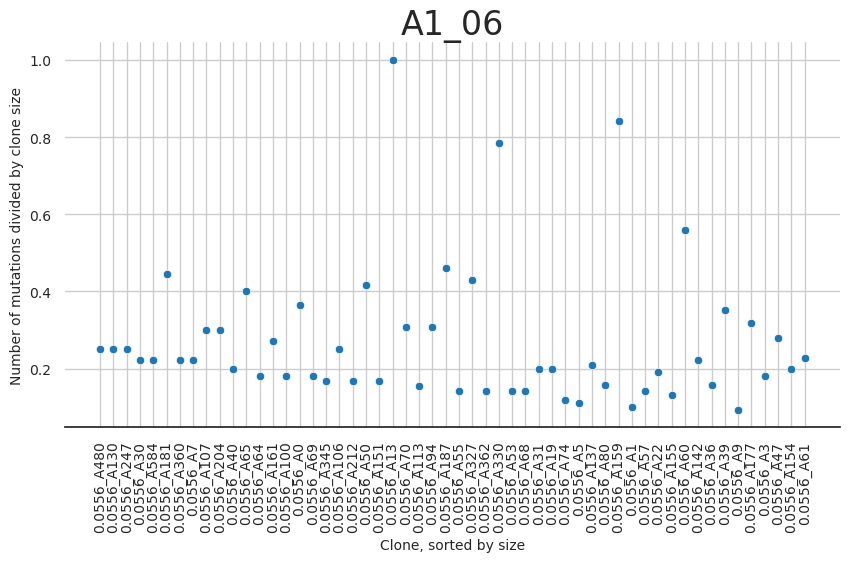

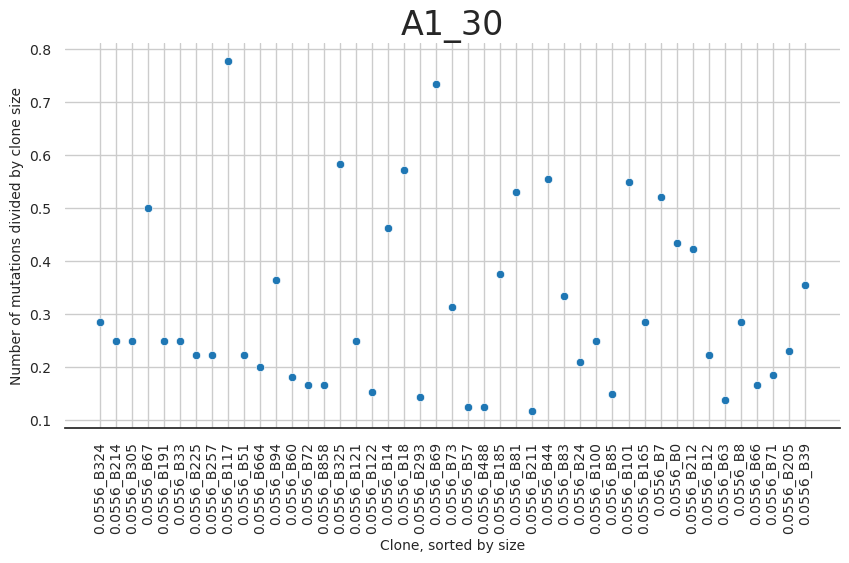

In [37]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor]['n_muts_div_size'] = performance[donor]['n_muts'] / performance[donor]['clone_size']
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.scatterplot(data=performance[donor], x=performance[donor].index, y="n_muts_div_size", lw=1) #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Number of mutations divided by clone size')
        plt.xlabel('Clone, sorted by size')
        plt.show()

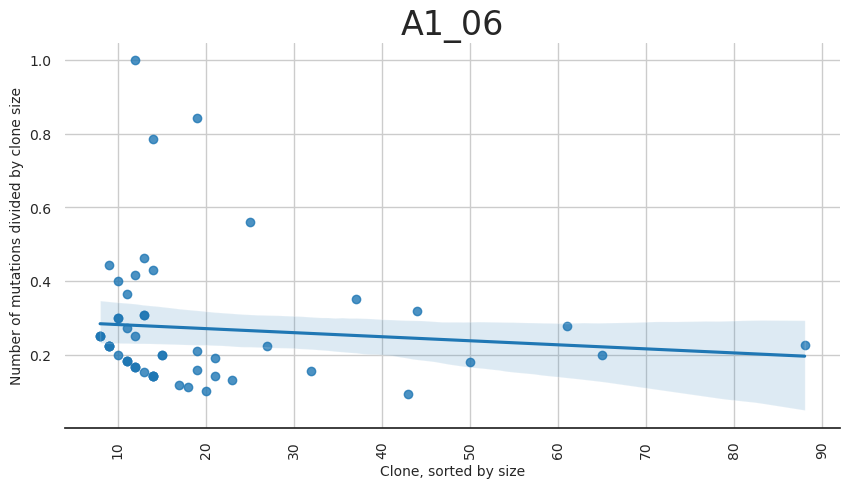

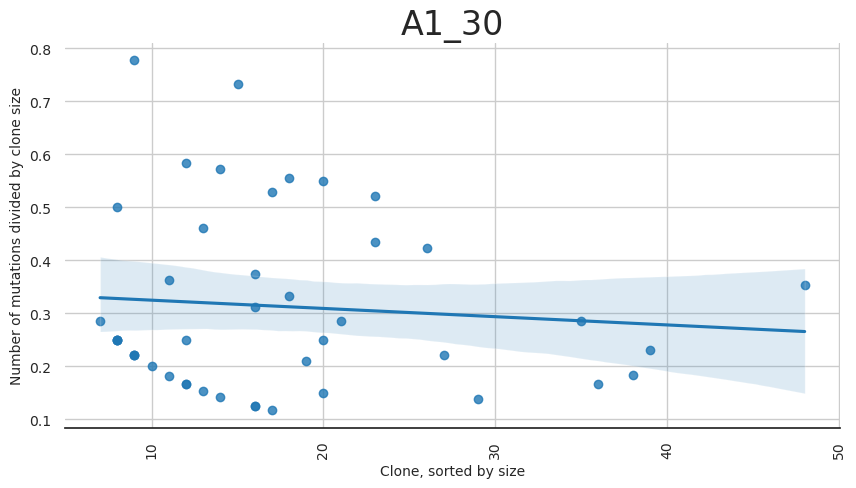

In [38]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor]['n_muts_div_size'] = performance[donor]['n_muts'] / performance[donor]['clone_size']
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.regplot(data=performance[donor], x="clone_size", y="n_muts_div_size") #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Number of mutations divided by clone size')
        plt.xlabel('Clone, sorted by size')
        plt.show()

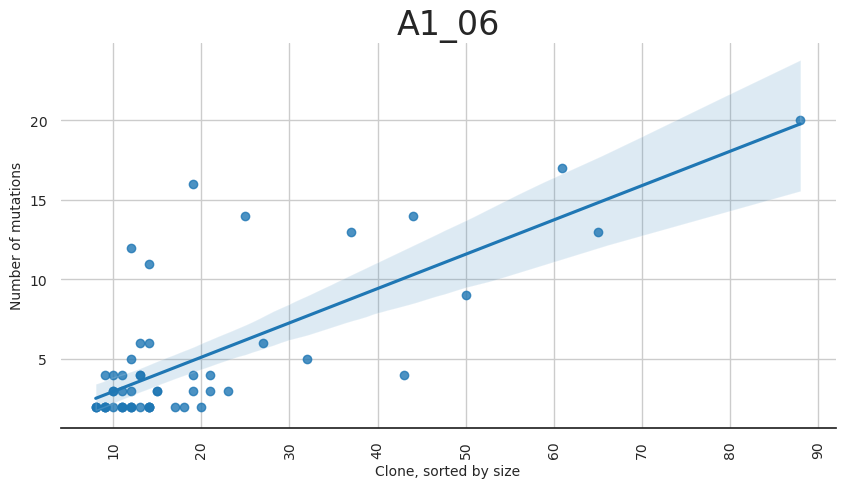

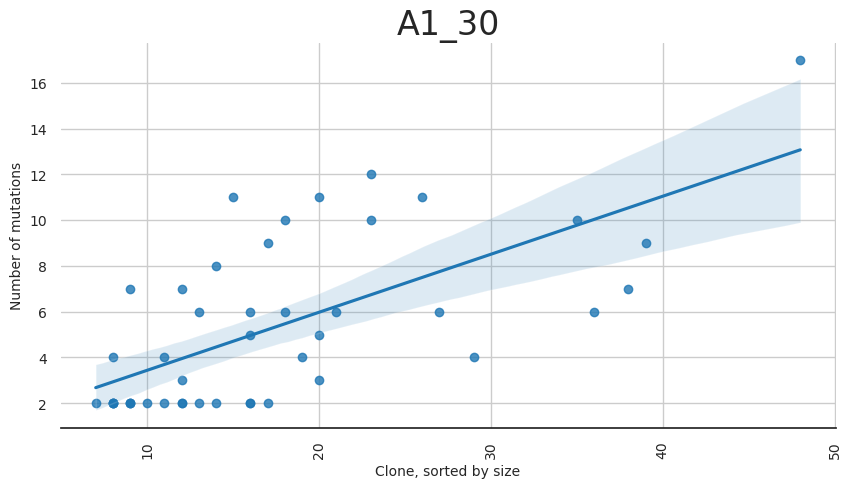

In [40]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor]['n_muts_div_size'] = performance[donor]['n_muts'] / performance[donor]['clone_size']
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.regplot(data=performance[donor], x="clone_size", y="n_muts") #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Number of mutations')
        plt.xlabel('Clone, sorted by size')
        plt.show()

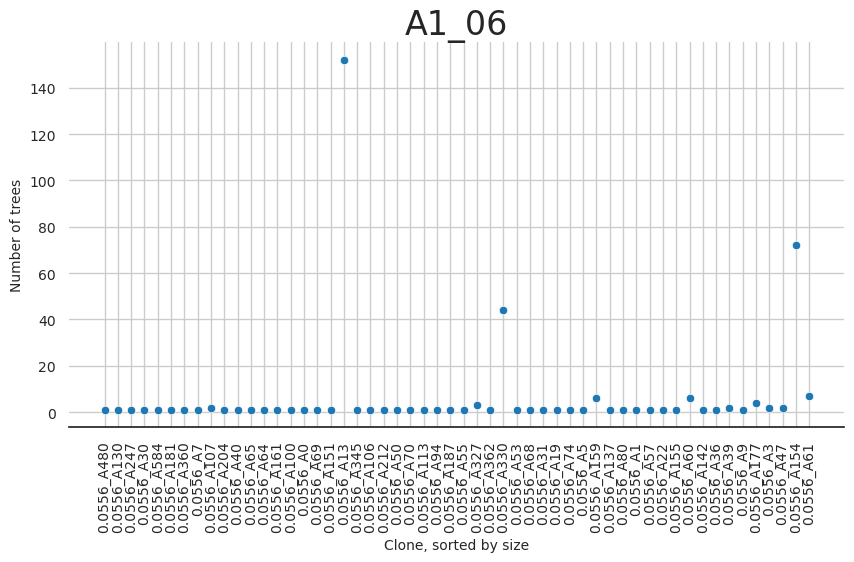

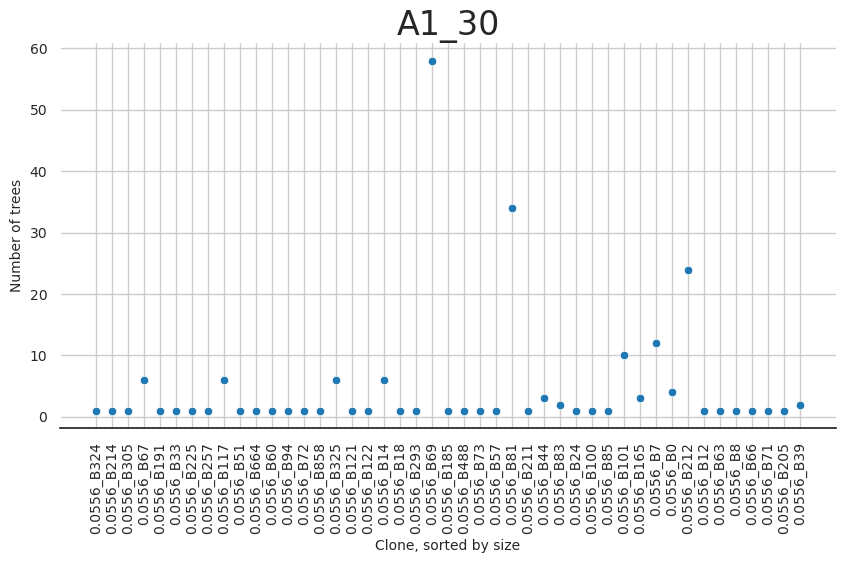

In [31]:
for donor in datasets:
    with plot_style(figsize=(10, 5), ticklabelsize=10, labelsize=10):
        performance[donor] = performance[donor].sort_values('clone_size')
        sns.scatterplot(data=performance[donor], x=performance[donor].index, y="n trees", lw=1) #marker='o'
        plt.grid(axis='both')
        plt.title(donor)
        #ax.set_xlim(0, 20)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Number of trees')
        plt.xlabel('Clone, sorted by size')
        plt.show()

In [66]:
len(performance['A1_06'].index) 

41

In [67]:
len(performance['A1_30'].index)

36